In [1]:
from pong import make_env

from time import sleep

In [2]:
import torch
import torch.nn.functional as F

from torch import nn, optim

In [3]:
device = torch.device('cpu')

In [4]:
env = make_env()

In [5]:
n = env.n
a = env.a

Hyperparameters

In [22]:
n_episodes = 8000
n_episodes_test = 100
lr = 1e-3
max_steps = 300
gamma = 0.99

## Create Model

In [7]:
class Policy(nn.Sequential):  
    @torch.no_grad()
    def act(self, observation, probabilistic=True):
        if not torch.is_tensor(observation):
            observation = torch.tensor(observation, device=device)
            
        if not probabilistic: 
            return self(observation).max(dim=-1)[1].long()
        else:
            return torch.multinomial(F.softmax(self(observation), dim=-1), 1).long()
        
policy = Policy(nn.Linear(n, 20, bias=False), nn.ReLU(), nn.Linear(20, a, bias=False)).to(device)

In [8]:
optimizer = optim.RMSprop(policy.parameters(), lr)

## Train

In [9]:
rewards = []
losses = []

In [10]:
def train_one_step(states, actions, reward):    
    states = torch.tensor(np.stack(states), device=device)
    actions = torch.tensor(np.stack(actions), device=device)
    # Actions in the beginning are more important to the reward
    rewards = gamma ** torch.arange(len(states), dtype=torch.float, device=device)
    rewards *= reward
    
    optimizer.zero_grad()
    action_scores = policy(states)
    
    loss = torch.mean(torch.stack([r * F.cross_entropy(s.unsqueeze(0), a.unsqueeze(0),
                                                       reduction='none')
                                   for s, a, r in zip(action_scores, actions, rewards)]))
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [11]:
def test_one_episode():
    state = env.reset()
    done = False
    total_rewards = 0
    
    for step in range(max_steps):
        action = policy.act(state).item()
        next_state, reward, done, _ = env.step(action)
        
        total_rewards += reward
        state = next_state
        if done: break
            
    return total_rewards

In [23]:
pbar = tqdm(range(len(rewards) * 10, n_episodes))

for episode in pbar:
    state = env.reset()
    done = False
    
    states, actions = [], []
    for step in range(max_steps):
        action = policy.act(state).item()
        states.append(state); actions.append(action)

        state, reward, done, _ = env.step(action)
        reward = np.float32(reward)

        if reward != 0: 
            loss = train_one_step(states, actions, reward)
            losses.append(loss)
            states.clear(); actions.clear()

        if done: break
    
    if not episode % 10: rewards.append(test_one_episode())
    pbar.set_description(f'{rewards[-1]:.2f}')

In [24]:
torch.save(policy.state_dict(), DIR_NB / 'policy_reduced.pt')

In [25]:
groupmean = lambda x, n=1: [sum(x[i:i + n]) / n for i in range(0, len(x) - n, n)]

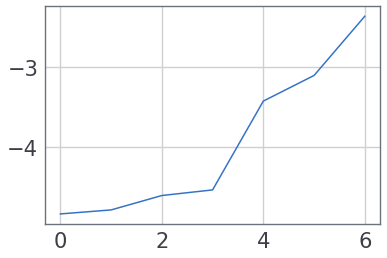

In [26]:
plot(groupmean(rewards, 100))

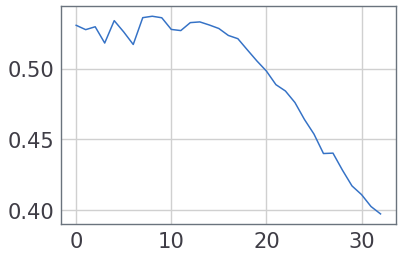

In [27]:
plot(groupmean(np.abs(losses), 1000))

In [31]:
for episode in range(1):
    state = env.reset()
    done = False
    total_rewards = 0

    for step in range(500):
        env.render()
        action = policy.act(state, probabilistic=False).item()
        with torch.no_grad():
            a = policy(torch.tensor(state, device=device)).cpu().numpy()
            a = np.log(np.abs(a[1] - a[0]))
            print(a)
        state, reward, done, _ = env.step(action)
        total_rewards += reward
        
        sleep(0.01)
        if done: break

    env.close()
    print(total_rewards)

-2.7022104
0.17921504
0.17921504
-1.0593983
-1.2939402
-1.6837759
0.38980815
-0.24711898
0.021783726
-1.2045342
0.33031538
-0.24711898
0.021783726
-1.2045342
0.33031538
-0.3364762
0.8058297
0.5403801
-2.235663
-0.28306615
-1.3624887
-1.7262619
-0.10800173
-2.2603202
0.5871665
0.08547086
-2.5029566
-0.47424158
-0.3117469
-1.5371778
-0.075555176
0.23072326
-0.44825956
-2.3594594
0.13552871
0.063309476
-1.1747477
-0.39522985
-0.2886945
-0.4097811
-0.83014685
-0.68945247
-0.07347818
-0.32968637
-0.5344514
-0.85690665
-0.70871514
-0.16110972
-1.7557504
0.2780176
0.9056303
0.973069
0.09533718
-1.5949333
-0.58144605
-0.9151792
-0.05986691
-0.34178942
-0.34992915
-0.31304914
-0.62105596
-0.8932193
-0.16317561
-0.45454976
-1.1576958
0.644154
0.69396913
-0.04346232
-1.3985062
-0.37677202
-0.70314234
-0.6005759
-0.0615851
-5.405268
0.6391655
0.3916157
-1.8331562
0.16184643
-1.4440166
-1.7228336
2.1577578
1.5727
1.1718409
0.71317554
0.1471077
-1.0258965
-0.4598411
-0.97114825
-0.57066387
-0.140955